In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics import pairwise_distances
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [52]:
df = pd.read_csv('SongMovies/SongMovies1k.csv', parse_dates=['movie_Released'])

In [53]:
numerical_cols = df.columns.drop(['movie_Released', 'movie_Genre', 'movie_Runtime', 'movie_BoxOffice', 'movie_imdbRating'])
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical columns (one-hot encode them)
categorical_cols = ['movie_Genre']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
])

# Separate features and target variables
X = df.drop(['movie_Runtime', 'movie_BoxOffice', 'movie_imdbRating'], axis=1)
y = df[['movie_Runtime', 'movie_BoxOffice', 'movie_imdbRating']]

# Convert 'movie_Released' into a numerical feature by calculating the number of days since the minimum date
X['movie_Released'] = (X['movie_Released'] - X['movie_Released'].min()).dt.days

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [55]:
# Model definition
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='relu') # Output layer
])
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='mse', metrics=['mae'])

In [56]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/100
20/20 [==============================] - 1s 11ms/step - loss: 5922627830939648.0000 - mae: 43982340.0000 - val_loss: 5869840535388160.0000 - val_mae: 43788460.0000
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 5922627830939648.0000 - mae: 43982336.0000 - val_loss: 5869839998517248.0000 - val_mae: 43788460.0000
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 5922626757197824.0000 - mae: 43982336.0000 - val_loss: 5869839461646336.0000 - val_mae: 43788456.0000
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 5922626220326912.0000 - mae: 43982328.0000 - val_loss: 5869838387904512.0000 - val_mae: 43788444.0000
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 5922624072843264.0000 - mae: 43982316.0000 - val_loss: 5869835703549952.0000 - val_mae: 43788436.0000
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 5922621925359616.0000 - mae: 43982300.0000 - val_lo

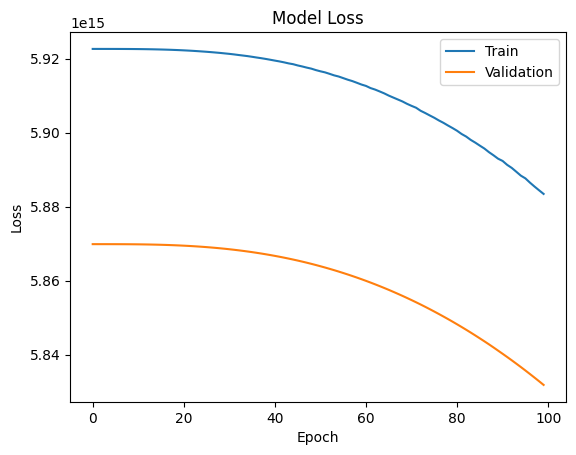

In [57]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [58]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

# Predictions
y_pred = model.predict(X_test)

# Mean Cosine Similarity and Mean Euclidean Distance functions
def mean_cosine_similarity(y_true, y_pred):
    cosine_similarities = 1 - pairwise_distances(y_pred, y_true, metric='cosine')
    return np.mean(np.diag(cosine_similarities))

def mean_euclidean_distance(y_true, y_pred):
    euclidean_distances = pairwise_distances(y_pred, y_true, metric='euclidean')
    return np.mean(np.diag(euclidean_distances))

# Calculate metrics for numerical parts
cosine_sim = mean_cosine_similarity(y_test, y_pred)
euclidean_dist = mean_euclidean_distance(y_test, y_pred)
print(f'Mean Cosine Similarity: {cosine_sim}')
print(f'Mean Euclidean Distance: {euclidean_dist}')
print(y_pred[0], " vs ", y_test[0])

# Loop through each feature
for i in range(y_test.shape[1]):
    plt.figure()
    plt.scatter(y_test[:, i], y_pred[:, i])
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted for Feature {i+1}')
    plt.plot([y_test[:, i].min(), y_test[:, i].max()], [y_test[:, i].min(), y_test[:, i].max()], 'k--', lw=4)
    plt.show()

plt.hist(y_pred.flatten(), bins=50, alpha=0.5, label='Scaled Predictions')
plt.legend()
plt.title('Histogram of Scaled Predictions')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Plot histogram of the scaled actual values
plt.hist(y_test.flatten(), bins=50, alpha=0.5, label='Scaled Actual Values')
plt.legend()
plt.title('Histogram of Scaled Actual Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

7/7 [==============================] - 0s 1ms/step - loss: 5791417116917760.0000 - mae: 43513972.0000
Test Loss: 5791417116917760.0, Test MAE: 43513972.0
7/7 [==============================] - 0s 1ms/step
Mean Cosine Similarity: 0.9999999813792642
Mean Euclidean Distance: 130541879.42406867


KeyError: 0